# TimeGPT

In [1]:
#| default_exp timegpt

In [2]:
#| hide 
%load_ext autoreload
%autoreload 2

In [3]:
#| export
import time 
import functools
import inspect
import json
import logging
import os
import requests
import warnings
from typing import Dict, List, Optional, Union

import numpy as np
import pandas as pd
from tenacity import (
    retry, stop_after_attempt, 
    wait_fixed, stop_after_delay,
    RetryCallState, 
    retry_if_exception, 
    retry_if_not_exception_type,
)
from utilsforecast.processing import (
    backtest_splits,
    drop_index_if_pandas,
    join,
    maybe_compute_sort_indices,
    take_rows,
    vertical_concat,
)

from nixtlats.client import (
    ApiError, Nixtla, 
    SingleSeriesForecast, MultiSeriesForecast, 
    MultiSeriesAnomaly, MultiSeriesInsampleForecast,
)

logging.basicConfig(level=logging.INFO)
main_logger = logging.getLogger(__name__)
httpx_logger = logging.getLogger('httpx')
httpx_logger.setLevel(logging.ERROR)

In [4]:
#| hide
import os
import warnings
from itertools import product

from dotenv import load_dotenv
from fastcore.test import test_eq, test_fail, test_warns
from nbdev.showdoc import show_doc
from tqdm import TqdmExperimentalWarning

load_dotenv()
logging.getLogger('statsforecast').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)

In [5]:
#| exporti
def deprecated_argument(old_name, new_name):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            if old_name in kwargs:
                warnings.warn(f"'{old_name}' is deprecated; use '{new_name}' instead.", FutureWarning)
                if new_name in kwargs:
                    raise TypeError(f"{new_name} argument duplicated")
                kwargs[new_name] = kwargs.pop(old_name)
            return func(*args, **kwargs)
        return wrapper
    return decorator

In [6]:
#| exporti
deprecated_finetune_steps = deprecated_argument("finetune_steps", "fewshot_steps")
deprecated_finetune_loss = deprecated_argument("finetune_loss", "fewshot_loss")

In [7]:
#| exporti
date_features_by_freq = {
    # Daily frequencies
    'B': ['year', 'month', 'day', 'weekday'],
    'C': ['year', 'month', 'day', 'weekday'],
    'D': ['year', 'month', 'day', 'weekday'],
    # Weekly
    'W': ['year', 'week', 'weekday'],
    # Monthly
    'M': ['year', 'month'],
    'SM': ['year', 'month', 'day'],
    'BM': ['year', 'month'],
    'CBM': ['year', 'month'],
    'MS': ['year', 'month'],
    'SMS': ['year', 'month', 'day'],
    'BMS': ['year', 'month'],
    'CBMS': ['year', 'month'],
    # Quarterly
    'Q': ['year', 'quarter'],
    'BQ': ['year', 'quarter'],
    'QS': ['year', 'quarter'],
    'BQS': ['year', 'quarter'],
    # Yearly
    'A': ['year'],
    'Y': ['year'],
    'BA': ['year'],
    'BY': ['year'],
    'AS': ['year'],
    'YS': ['year'],
    'BAS': ['year'],
    'BYS': ['year'],
    # Hourly
    'BH': ['year', 'month', 'day', 'hour', 'weekday'],
    'H': ['year', 'month', 'day', 'hour'],
    # Minutely
    'T': ['year', 'month', 'day', 'hour', 'minute'],
    'min': ['year', 'month', 'day', 'hour', 'minute'],
    # Secondly
    'S': ['year', 'month', 'day', 'hour', 'minute', 'second'],
    # Milliseconds
    'L': ['year', 'month', 'day', 'hour', 'minute', 'second', 'millisecond'],
    'ms': ['year', 'month', 'day', 'hour', 'minute', 'second', 'millisecond'],
    # Microseconds
    'U': ['year', 'month', 'day', 'hour', 'minute', 'second', 'microsecond'],
    'us': ['year', 'month', 'day', 'hour', 'minute', 'second', 'microsecond'],
    # Nanoseconds
    'N': []
}

## _TimeGPTModel

In [8]:
#| exporti
class _TimeGPTModel:

    def __init__(
            self, 
            client: Nixtla,
            h: int,
            id_col: str = 'unique_id',
            time_col: str = 'ds',
            target_col: str = 'y',
            freq: str = None,
            level: Optional[List[Union[int, float]]] = None,
            quantiles: Optional[List[float]] = None,
            fewshot_steps: int = 0,
            fewshot_loss: str = 'default',
            clean_ex_first: bool = True,
            date_features: Union[bool, List[str]] = False,
            date_features_to_one_hot: Union[bool, List[str]] = True,
            model: str = 'short-horizon',
            max_retries: int = 6,
            retry_interval: int = 10,
            max_wait_time: int = 6 * 60,
        ):
        self.client = client
        self.h = h
        self.id_col = id_col
        self.time_col = time_col
        self.target_col = target_col
        self.base_freq = freq
        self.level, self.quantiles = self._prepare_level_and_quantiles(level, quantiles)
        self.fewshot_steps = fewshot_steps
        self.fewshot_loss = fewshot_loss
        self.clean_ex_first = clean_ex_first
        self.date_features = date_features
        self.date_features_to_one_hot = date_features_to_one_hot
        self.model = model
        self.max_retries = max_retries
        self.retry_interval = retry_interval
        self.max_wait_time = max_wait_time
        # variables defined by each flow
        self.weights_x: pd.DataFrame = None
        self.freq: str = self.base_freq
        self.drop_uid: bool = False
        self.x_cols: List[str]
        self.input_size: int
        self.model_horizon: int

    @staticmethod
    def _prepare_level_and_quantiles(
        level: Optional[List[Union[int, float]]], 
        quantiles: Optional[List[float]],
    ):
        if (level is not None) and (quantiles is not None):
            raise Exception(
                "you should include `level` or `quantiles` but not both."
            )
        if quantiles is None:
            return level, quantiles
        # we recover level from quantiles
        if not all(0 < q < 1 for q in quantiles):
            raise Exception(
                "`quantiles` should lie between 0 and 1"
            )
        level = [abs(int(100 - 200 * q)) for q in quantiles]
        return level, quantiles
        

    def _retry_strategy(self):
        def after_retry(retry_state: RetryCallState):
            """Called after each retry attempt."""
            main_logger.info(f"Attempt {retry_state.attempt_number} failed...")
        # we want to retry when:
        # there is no ApiError 
        # there is an ApiError with string body
        def is_api_error_with_text_body(exception):
            if isinstance(exception, ApiError):
                if isinstance(exception.body, str):
                    return True
            return False
        return retry(
            stop=(stop_after_attempt(self.max_retries) | stop_after_delay(self.max_wait_time)),
            wait=wait_fixed(self.retry_interval),
            reraise=True,
            after=after_retry,
            retry=retry_if_exception(is_api_error_with_text_body) | retry_if_not_exception_type(ApiError),
        )

    def _call_api(self, method, request):
        response = self._retry_strategy()(method)(request=request)
        if 'data' in response:
            response = response['data']
        return response

    def transform_inputs(self, df: pd.DataFrame, X_df: pd.DataFrame):
        df = df.copy()
        main_logger.info("Validating inputs...")
        if self.base_freq is None and hasattr(df.index, "freq"):
            inferred_freq = df.index.freq
            if inferred_freq is not None:
                inferred_freq = inferred_freq.rule_code
                main_logger.info(f"Inferred freq: {inferred_freq}")
            self.freq = inferred_freq
            time_col = df.index.name if df.index.name else "ds"
            self.time_col = time_col
            df.index.name = time_col
            df = df.reset_index()
        else:
            self.freq = self.base_freq
        renamer = {
            self.id_col: "unique_id",
            self.time_col: "ds",
            self.target_col: "y",
        }
        df = df.rename(columns=renamer)
        if df.dtypes.ds != "object":
            df["ds"] = df["ds"].astype(str)
        if "unique_id" not in df.columns:
            # Insert unique_id column
            df = df.assign(unique_id="ts_0")
            self.drop_uid = True
        if X_df is not None:
            X_df = X_df.copy()
            X_df = X_df.rename(columns=renamer)
            if "unique_id" not in X_df.columns:
                X_df = X_df.assign(unique_id="ts_0")
            if X_df.dtypes.ds != "object":
                X_df["ds"] = X_df["ds"].astype(str)
        return df, X_df

    def transform_outputs(self, fcst_df: pd.DataFrame, level_to_quantiles: bool = False):
        renamer = {
            'unique_id': self.id_col,
            'ds': self.time_col,
            'y': self.target_col,
        }
        if self.drop_uid:
            fcst_df = fcst_df.drop(columns='unique_id')
        fcst_df = fcst_df.rename(columns=renamer)
        # transfom levels to quantiles if needed
        if level_to_quantiles and self.quantiles is not None:
            cols = [col for col in fcst_df.columns if ('-lo-' not in col) and ('-hi-' not in col)]
            for q in sorted(self.quantiles):
                if q == 0.5:
                    col = 'TimeGPT'
                else:
                    lv = int(100 - 200 * q)
                    hi_or_lo = 'lo' if lv > 0 else 'hi'
                    lv = abs(lv)
                    col = f"TimeGPT-{hi_or_lo}-{lv}"
                q_col = f"TimeGPT-q-{int(q * 100)}"
                fcst_df[q_col] = fcst_df[col].values
                cols.append(q_col)
            fcst_df = fcst_df[cols]
        return fcst_df

    def infer_freq(self, df: pd.DataFrame):
        # special freqs that need to be checked
        # for example to ensure 'W'-> 'W-MON'
        special_freqs = ['W', 'M', 'Q', 'Y', 'A']
        if self.freq is None or self.freq in special_freqs:
            unique_id = df.iloc[0]['unique_id']
            df_id = df.query('unique_id == @unique_id')
            inferred_freq = pd.infer_freq(df_id['ds'].sort_values())
            if inferred_freq is None:
                raise Exception(
                    'Could not infer frequency of ds column. This could be due to '
                    'inconsistent intervals. Please check your data for missing, '
                    'duplicated or irregular timestamps'
                )
            if self.freq is not None:
                # check we have the same base frequency
                # except when we have yearly frequency (A, and Y means the same)
                if (self.freq != inferred_freq[0] and self.freq != 'Y') or (self.freq == 'Y' and inferred_freq[0] != 'A'):
                    raise Exception(f'Failed to infer special date, inferred freq {inferred_freq}')
            main_logger.info(f'Inferred freq: {inferred_freq}')
            self.freq = inferred_freq

    def resample_dataframe(self, df: pd.DataFrame):
        df = df.copy()
        df['ds'] = pd.to_datetime(df['ds'])
        resampled_df = df.set_index('ds').groupby('unique_id').resample(self.freq).bfill()
        resampled_df = resampled_df.drop(columns='unique_id').reset_index()
        resampled_df['ds'] = resampled_df['ds'].astype(str)
        return resampled_df

    def make_future_dataframe(self, df: pd.DataFrame, reconvert: bool = True):
        last_dates = df.groupby('unique_id')['ds'].max()
        def _future_date_range(last_date):
            future_dates = pd.date_range(last_date, freq=self.freq, periods=self.h + 1)
            future_dates = future_dates[-self.h:]
            return future_dates
        future_df = last_dates.apply(_future_date_range).reset_index()
        future_df = future_df.explode('ds').reset_index(drop=True)
        if reconvert and df.dtypes['ds'] == 'object':
            # avoid date 000
            future_df['ds'] = future_df['ds'].astype(str)
        return future_df

    def compute_date_feature(self, dates, feature):
        if callable(feature):
            feat_name = feature.__name__
            feat_vals = feature(dates)
        else:
            feat_name = feature
            if feature in ("week", "weekofyear"):
                dates = dates.isocalendar()
            feat_vals = getattr(dates, feature)
        if not isinstance(feat_vals, pd.DataFrame):
            vals = np.asarray(feat_vals)
            feat_vals = pd.DataFrame({feat_name: vals})
        feat_vals['ds'] = dates
        return feat_vals

    def add_date_features( 
            self,
            df: pd.DataFrame,
            X_df: Optional[pd.DataFrame],
        ):
        # df contains exogenous variables
        # X_df are the future values of the exogenous variables
        # construct dates
        train_dates = df['ds'].unique().tolist()
        # if we dont have future exogenos variables
        # we need to compute the future dates
        if (self.h is not None) and X_df is None:
            X_df = self.make_future_dataframe(df=df)
            future_dates = X_df['ds'].unique().tolist()
        elif X_df is not None:
            future_dates = X_df['ds'].unique().tolist()
        else:
            future_dates = []
        dates = pd.DatetimeIndex(np.unique(train_dates + future_dates).tolist())
        date_features_df = pd.DataFrame({'ds': dates})
        for feature in self.date_features:
            feat_df = self.compute_date_feature(dates, feature)
            date_features_df = date_features_df.merge(feat_df, on=['ds'], how='left')
        if df.dtypes['ds'] == 'object':
            date_features_df['ds'] = date_features_df['ds'].astype(str)
        if self.date_features_to_one_hot is not None:
            date_features_df = pd.get_dummies(
                date_features_df, 
                columns=self.date_features_to_one_hot, 
                dtype=int,
            )
        # remove duplicated columns if any
        date_features_df = date_features_df.drop(
            columns=[col for col in date_features_df.columns if col in df.columns and col not in ['unique_id', 'ds']]
        )
        # add date features to df
        df = df.merge(date_features_df, on='ds', how='left')
        # add date features to X_df
        if X_df is not None:
            X_df = X_df.merge(date_features_df, on='ds', how='left')
        return df, X_df

    def preprocess_X_df(self, X_df: pd.DataFrame):
        if X_df.isna().any().any():
            raise Exception('Some of your exogenous variables contain NA, please check')
        X_df = X_df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
        X_df = self.resample_dataframe(X_df)
        return X_df

    def preprocess_dataframes(
            self, 
            df: pd.DataFrame, 
            X_df: Optional[pd.DataFrame],
        ):
        self.infer_freq(df=df)
        """Returns Y_df and X_df dataframes in the structure expected by the endpoints."""
        # add date features logic
        if isinstance(self.date_features, bool):
            if self.date_features:
                self.date_features = date_features_by_freq.get(self.freq)
                if self.date_features is None:
                    warnings.warn(
                        f'Non default date features for {self.freq} '
                        'please pass a list of date features'
                    )
            else:
                self.date_features = None
                
        if self.date_features is not None:
            if isinstance(self.date_features_to_one_hot, bool):
                if self.date_features_to_one_hot:
                    self.date_features_to_one_hot = [feat for feat in self.date_features if not callable(feat)]
                    self.date_features_to_one_hot = None if not self.date_features_to_one_hot else self.date_features_to_one_hot
                else:
                    self.date_features_to_one_hot = None
            df, X_df = self.add_date_features(df=df, X_df=X_df)
        y_cols = ['unique_id', 'ds', 'y']
        Y_df = df[y_cols]
        if Y_df['y'].isna().any():
            raise Exception('Your target variable contains NA, please check')
        # Azul: efficient this code
        # and think about returning dates that are not in the training set
        Y_df = self.resample_dataframe(Y_df)
        x_cols = []
        if X_df is not None:
            x_cols = X_df.drop(columns=['unique_id', 'ds']).columns.to_list()
            if not all(col in df.columns for col in x_cols):
                raise Exception(
                    'You must include the exogenous variables in the `df` object, '
                    f'exogenous variables {",".join(x_cols)}'
                )
            if (self.h is not None) and (len(X_df) != df['unique_id'].nunique() * self.h):
                raise Exception(
                    f'You have to pass the {self.h} future values of your '
                    'exogenous variables for each time series'
                )
            X_df_history = df[['unique_id', 'ds'] + x_cols]
            X_df = pd.concat([X_df_history, X_df])
            X_df = self.preprocess_X_df(X_df)
        elif (X_df is None) and (self.h is None) and (len(y_cols) < df.shape[1]):
            # case for just insample, 
            # we dont need h
            X_df = df.drop(columns='y')
            x_cols = X_df.drop(columns=['unique_id', 'ds']).columns.to_list()
            X_df = self.preprocess_X_df(X_df)
        self.x_cols = x_cols
        return Y_df, X_df

    def dataframes_to_dict(self, Y_df: pd.DataFrame, X_df: pd.DataFrame):
        to_dict_args = {'orient': 'split'}
        if 'index' in inspect.signature(pd.DataFrame.to_dict).parameters:
            to_dict_args['index'] = False
        y = Y_df.to_dict(**to_dict_args)
        x = X_df.to_dict(**to_dict_args) if X_df is not None else None
        # A: I'm aware that sel.x_cols exists, but
        # I want to be sure that we are logging the correct
        # x cols :kiss:
        if x:
            x_cols = [col for col in x['columns'] if col not in ['unique_id', 'ds']]
            main_logger.info(f'Using the following exogenous variables: {", ".join(x_cols)}')
        return y, x
    
    def set_model_params(self):
        model_params = self._call_api(
            self.client.model_params,
            SingleSeriesForecast(freq=self.freq, model=self.model),
        )
        model_params = model_params['detail']
        self.input_size, self.model_horizon = model_params['input_size'], model_params['horizon']
    
    def validate_input_size(self, Y_df: pd.DataFrame):
        min_history = Y_df.groupby('unique_id').size().min()
        if min_history < self.input_size + self.model_horizon:
            raise Exception(
                'Your time series data is too short '

                'Please be sure that your unique time series contain '
                f'at least {self.input_size + self.model_horizon} observations'
            )

    def forecast(
        self,
        df: pd.DataFrame,
        X_df: Optional[pd.DataFrame] = None,
        add_history: bool = False,
    ):
        df, X_df = self.transform_inputs(df=df, X_df=X_df)
        main_logger.info('Preprocessing dataframes...')
        Y_df, X_df = self.preprocess_dataframes(df=df, X_df=X_df)
        self.set_model_params()
        if self.h > self.model_horizon:
            main_logger.warning(
                'The specified horizon "h" exceeds the model horizon. '
                'This may lead to less accurate forecasts. '
                'Please consider using a smaller horizon.'
            )
        # restrict input if
        # - we dont want to fewshot
        # - we dont have exogenous regegressors
        # - and we dont want to produce pred intervals
        # - no add history
        restrict_input = self.fewshot_steps == 0 and X_df is None and self.level is not None and not add_history
        if restrict_input:
            # add sufficient info to compute
            # conformal interval
            main_logger.info('Restricting input...')
            new_input_size = 3 * self.input_size + max(self.model_horizon, self.h)
            Y_df = Y_df.groupby("unique_id").tail(new_input_size)
            if X_df is not None:
                X_df = X_df.groupby("unique_id").tail(
                    new_input_size + self.h
                )  # history plus exogenous
        if self.fewshot_steps > 0 or self.level is not None:
            self.validate_input_size(Y_df=Y_df)
        y, x = self.dataframes_to_dict(Y_df, X_df)
        main_logger.info('Calling Forecast Endpoint...')
        payload = MultiSeriesForecast(
            y=y,
            x=x,
            fh=self.h,
            freq=self.freq,
            level=self.level,
            fewshot_steps=self.fewshot_steps,
            fewshot_loss=self.fewshot_loss,
            clean_ex_first=self.clean_ex_first,
            model=self.model,
        )
        response_timegpt = self._call_api(
            self.client.forecast_multi_series,
            payload,
        )
        self.response_timegpt = response_timegpt
        if 'weights_x' in response_timegpt:
            self.weights_x = pd.DataFrame({
                'features': self.x_cols,
                'weights': response_timegpt['weights_x'],
            })
        fcst_df = pd.DataFrame(**response_timegpt['forecast'])
        if add_history:
            main_logger.info('Calling Historical Forecast Endpoint...')
            self.validate_input_size(Y_df=Y_df)
            response_timegpt = self._call_api(
                self.client.historic_forecast_multi_series,
                MultiSeriesInsampleForecast(
                    y=y,
                    x=x,
                    freq=self.freq,
                    level=self.level,
                    clean_ex_first=self.clean_ex_first,
                    model=self.model,
                ),
            )
            fitted_df = pd.DataFrame(**response_timegpt['forecast'])
            fitted_df = fitted_df.drop(columns='y')
            fcst_df = pd.concat([fitted_df, fcst_df]).sort_values(['unique_id', 'ds'])
        fcst_df = self.transform_outputs(fcst_df, level_to_quantiles=True)
        return fcst_df

    def request_df(self): 
        if hasattr(self, 'response_timegpt'):
            return self.response_timegpt
        else: 
            raise Exception('You must call a method from the TimeGPT class first')

    def detect_anomalies(self, df: pd.DataFrame):
        # Azul
        # Remember the input X_df is the FUTURE ex vars
        # there is a misleading notation here
        # because X_df inputs in the following methods
        # returns X_df outputs that means something different
        # ie X_df = [X_df_history, X_df]
        # exogenous variables are passed after df 
        df, _ = self.transform_inputs(df=df, X_df=None)
        main_logger.info('Preprocessing dataframes...')
        Y_df, X_df = self.preprocess_dataframes(df=df, X_df=None)
        main_logger.info('Calling Anomaly Detector Endpoint...')
        y, x = self.dataframes_to_dict(Y_df, X_df)
        response_timegpt = self._call_api(
            self.client.anomaly_detection_multi_series,
            MultiSeriesAnomaly(
                y=y,
                x=x,
                freq=self.freq,
                level=[self.level] if (isinstance(self.level, int) or isinstance(self.level, float)) else [self.level[0]],
                clean_ex_first=self.clean_ex_first,
                model=self.model,
            ),
        )
        self.response_timegpt = response_timegpt
        if 'weights_x' in response_timegpt:
            self.weights_x = pd.DataFrame({
                'features': self.x_cols,
                'weights': response_timegpt['weights_x'],
            })
        anomalies_df = pd.DataFrame(**response_timegpt['forecast'])
        anomalies_df = anomalies_df.drop(columns='y')
        anomalies_df = self.transform_outputs(anomalies_df)
        return anomalies_df

    def cross_validation(
        self,
        df: pd.DataFrame,
        n_windows: int = 1,
        step_size: Optional[int] = None,
    ):
        # A: see `transform_inputs`
        # the code always will return X_df=None
        # if X_df=None
        df, _ = self.transform_inputs(df=df, X_df=None)
        self.infer_freq(df)
        df['ds'] = pd.to_datetime(df['ds'])
        # mlforecast cv code
        results = []
        sort_idxs = maybe_compute_sort_indices(df, "unique_id", "ds")
        if sort_idxs is not None:
            df = take_rows(df, sort_idxs)
        splits = backtest_splits(
            df,
            n_windows=n_windows,
            h=self.h,
            id_col="unique_id",
            time_col="ds",
            freq=pd.tseries.frequencies.to_offset(self.freq),
            step_size=self.h if step_size is None else step_size,
        )
        for i_window, (cutoffs, train, valid) in enumerate(splits):
            if len(valid.columns) > 3:
                # if we have uid, ds, y + exogenous vars
                train_future = valid.drop(columns='y')
            else:
                train_future = None
            y_pred, res  = self.forecast(
                df=train,
                X_df=train_future,
            )
            print(res)
            y_pred, _ = self.transform_inputs(df=y_pred, X_df=None)
            y_pred = join(y_pred, cutoffs, on="unique_id", how="left")
            y_pred["ds"] = pd.to_datetime(y_pred["ds"])
            result = join(
                valid[["unique_id", "ds", "y"]],
                y_pred,
                on=["unique_id", "ds"],
            )
            if result.shape[0] < valid.shape[0]:
                raise ValueError(
                    "Cross validation result produced less results than expected. "
                    "Please verify that the frequency parameter (freq) matches your series' "
                    "and that there aren't any missing periods."
                )
            results.append(result)
        out = vertical_concat(results)
        out = drop_index_if_pandas(out)
        first_out_cols = ["unique_id", "ds", "cutoff", "y"]
        remaining_cols = [c for c in out.columns if c not in first_out_cols]
        fcst_cv_df = out[first_out_cols + remaining_cols]
        fcst_cv_df["ds"] = fcst_cv_df["ds"].astype(str)
        fcst_cv_df = self.transform_outputs(fcst_cv_df)
        return fcst_cv_df, res 

In [9]:
#| exporti
def validate_model_parameter(func):
    def wrapper(self, *args, **kwargs):
        if 'model' in kwargs:
            model = kwargs['model']
            rename_models_dict = {
                'timegpt-1': 'short-horizon',
                'timegpt-1-long-horizon': 'long-horizon',
            }
            if model in rename_models_dict.keys():
                new_model = rename_models_dict[model]
                warnings.warn(f"'{model}' is deprecated; use '{new_model}' instead.", FutureWarning)
                model = new_model
            if model not in self.supported_models:
                raise ValueError(
                    f'unsupported model: {kwargs["model"]} '
                    f'supported models: {", ".join(self.supported_models)}'
                )
        return func(self, *args, **kwargs)
    return wrapper

In [10]:
#| exporti
def remove_unused_categories(df: pd.DataFrame, col: str):
    """Check if col exists in df and if it is a category column.
    In that case, it removes the unused levels."""
    if df is not None and col in df:
        if df[col].dtype == 'category':
            df = df.copy()
            df[col] = df[col].cat.remove_unused_categories()
    return df

In [11]:
#| exporti
def partition_by_uid(func):
    def wrapper(self, num_partitions, **kwargs):
        if num_partitions is None or num_partitions == 1:
            return func(self, **kwargs, num_partitions=1)
        df = kwargs.pop('df')
        X_df = kwargs.pop('X_df', None)
        id_col = kwargs['id_col']
        uids = df['unique_id'].unique()
        results_df = []
        for uids_split in np.array_split(uids, num_partitions):
            df_uids = df.query('unique_id in @uids_split')
            if X_df is not None:
                X_df_uids = X_df.query('unique_id in @uids_split')
            else:
                X_df_uids = None
            df_uids = remove_unused_categories(df_uids, col=id_col)
            X_df_uids = remove_unused_categories(X_df_uids, col=id_col)
            kwargs_uids = {'df': df_uids, **kwargs}
            if X_df_uids is not None:
                kwargs_uids['X_df'] = X_df_uids
            results_uids = func(self, **kwargs_uids, num_partitions=1)
            results_df.append(results_uids)
        results_df = pd.concat(results_df).reset_index(drop=True)
        return results_df
    return wrapper

## _TimeGPT

In [12]:
#| exporti
class _TimeGPT:
    """
    A class used to interact with the TimeGPT API.
    """

    def __init__(
            self, 
            token: Optional[str] = None, 
            environment: Optional[str] = None,
            max_retries: int = 6,
            retry_interval: int = 10,
            max_wait_time: int = 6 * 60,
        ):
        """
        Constructs all the necessary attributes for the TimeGPT object.

        Parameters
        ----------
        token : str, (default=None)
            The authorization token interacts with the TimeGPT API.
            If not provided, it will be inferred by the TIMEGPT_TOKEN environment variable.
        environment : str, (default=None)
            Custom environment. Pass only if provided.
        max_retries : int, (default=6)
            The maximum number of attempts to make when calling the API before giving up. 
            It defines how many times the client will retry the API call if it fails. 
            Default value is 6, indicating the client will attempt the API call up to 6 times in total
        retry_interval : int, (default=10)
            The interval in seconds between consecutive retry attempts. 
            This is the waiting period before the client tries to call the API again after a failed attempt. 
            Default value is 10 seconds, meaning the client waits for 10 seconds between retries.
        max_wait_time : int, (default=360)
            The maximum total time in seconds that the client will spend on all retry attempts before giving up. 
            This sets an upper limit on the cumulative waiting time for all retry attempts. 
            If this time is exceeded, the client will stop retrying and raise an exception. 
            Default value is 360 seconds, meaning the client will cease retrying if the total time 
            spent on retries exceeds 360 seconds. 
            The client throws a ReadTimeout error after 60 seconds of inactivity. If you want to 
            catch these errors, use max_wait_time >> 60. 
        """
        if token is None:
            token = os.environ.get("TIMEGPT_TOKEN")
        if token is None:
            raise Exception(
                'The token must be set either by passing `token` '
                'or by setting the TIMEGPT_TOKEN environment variable.'
            )
        if environment is None:
            environment = "https://dashboard.nixtla.io/api"
        self.client = Nixtla(base_url=environment, token=token)
        self.max_retries = max_retries
        self.retry_interval = retry_interval
        self.max_wait_time = max_wait_time
        self.supported_models = ['short-horizon', 'long-horizon'] 
        # custom attr
        self.weights_x: pd.DataFrame = None

    def validate_token(self, log: bool = True) -> bool:
        """Returns True if your token is valid."""
        validation = self.client.validate_token()
        valid = False
        if 'message' in validation:
            if validation['message'] == 'success':
                valid = True
        elif 'detail' in validation:
            if 'Forecasting! :)' in validation['detail']:
                valid = True
        if 'support' in validation and log:
            main_logger.info(f'Happy Forecasting! :), {validation["support"]}')
        return valid

    @validate_model_parameter
    @partition_by_uid
    def _forecast(
            self,
            df: pd.DataFrame,
            h: int,
            freq: Optional[str] = None,    
            id_col: str = 'unique_id',
            time_col: str = 'ds',
            target_col: str = 'y',
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[Union[int, float]]] = None,
            quantiles: Optional[List[float]] = None,
            fewshot_steps: int = 0,
            fewshot_loss: str = 'default',
            clean_ex_first: bool = True,
            validate_token: bool = False,
            add_history: bool = False,
            date_features: Union[bool, List[str]] = False,
            date_features_to_one_hot: Union[bool, List[str]] = True,
            model: str = 'short-horizon',
            num_partitions: int = 1,
        ):
        if validate_token and not self.validate_token(log=False):
            raise Exception(
                'Token not valid, please email ops@nixtla.io'
            )
        self.timegpt_model = _TimeGPTModel(
            client=self.client,
            h=h,
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
            freq=freq,
            level=level,
            quantiles=quantiles,
            fewshot_steps=fewshot_steps,
            fewshot_loss=fewshot_loss,
            clean_ex_first=clean_ex_first,
            date_features=date_features,
            date_features_to_one_hot=date_features_to_one_hot,
            model=model,
            max_retries=self.max_retries,
            retry_interval=self.retry_interval,
            max_wait_time=self.max_wait_time,   
        )
        fcst_df = self.timegpt_model.forecast(df=df, X_df=X_df, add_history=add_history) 
        self.weights_x = self.timegpt_model.weights_x
        self.endpoint = 'forecast'
        return fcst_df 
    
    def _request_df(self): 
        if hasattr(self, 'timegpt_model') and hasattr(self.timegpt_model, 'response_timegpt'):
            response = self.timegpt_model.response_timegpt
            res = pd.DataFrame({'input_tokens': [response['input_tokens']], 
                                'output_tokens': [response['output_tokens']], 
                                'finetune_tokens': [response['finetune_tokens']]
                                })
            res['endpoint'] = self.endpoint
            local_time = time.localtime(time.time())
            created_at = time.strftime("%Y-%m-%d %H:%M:%S", local_time)
            res['created_at'] = created_at
            res = res[['created_at', 'endpoint', 'input_tokens', 'output_tokens', 'finetune_tokens']]
            return res
        else:
            raise Exception('You must call a method from the TimeGPT class first')

    @validate_model_parameter
    @partition_by_uid
    def _detect_anomalies(
            self,
            df: pd.DataFrame,
            freq: Optional[str] = None,    
            id_col: str = 'unique_id',
            time_col: str = 'ds',
            target_col: str = 'y',
            level: Union[int, float] = 99,
            clean_ex_first: bool = True,
            validate_token: bool = False,
            date_features: Union[bool, List[str]] = False,
            date_features_to_one_hot: Union[bool, List[str]] = True,
            model: str = 'short-horizon',
            num_partitions: int = 1,
        ):
        if validate_token and not self.validate_token(log=False):
            raise Exception(
                'Token not valid, please email ops@nixtla.io'
            )
        self.timegpt_model = _TimeGPTModel(
            client=self.client,
            h=None,
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
            freq=freq,
            level=level,
            clean_ex_first=clean_ex_first,
            date_features=date_features,
            date_features_to_one_hot=date_features_to_one_hot,
            model=model,
            max_retries=self.max_retries,
            retry_interval=self.retry_interval,
            max_wait_time=self.max_wait_time,
        )
        anomalies_df = self.timegpt_model.detect_anomalies(df=df)
        self.weights_x = self.timegpt_model.weights_x
        self.endpoint = 'detect_anomalies'
        return anomalies_df 

    @validate_model_parameter
    @partition_by_uid
    def _cross_validation(
        self,
        df: pd.DataFrame,
        h: int,
        freq: Optional[str] = None,
        id_col: str = "unique_id",
        time_col: str = "ds",
        target_col: str = "y",
        level: Optional[List[Union[int, float]]] = None,
        quantiles: Optional[List[float]] = None,
        validate_token: bool = False,
        n_windows: int = 1,
        step_size: Optional[int] = None,
        fewshot_steps: int = 0,
        fewshot_loss: str = 'default',
        clean_ex_first: bool = True,
        date_features: Union[bool, List[str]] = False,
        date_features_to_one_hot: Union[bool, List[str]] = True,
        model: str = 'short-horizon',
        num_partitions: int = 1,
    ):
        if validate_token and not self.validate_token(log=False):
            raise Exception(
                'Token not valid, please email ops@nixtla.io'
            )
        timegpt_model = _TimeGPTModel(
            client=self.client,
            h=h,
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
            freq=freq,
            level=level,
            quantiles=quantiles,
            fewshot_steps=fewshot_steps,
            fewshot_loss=fewshot_loss,
            clean_ex_first=clean_ex_first,
            date_features=date_features,
            date_features_to_one_hot=date_features_to_one_hot,
            model=model,
            max_retries=self.max_retries,
            retry_interval=self.retry_interval,
            max_wait_time=self.max_wait_time,
        )
        cv_df, res = timegpt_model.cross_validation(df=df, n_windows=n_windows, step_size=step_size)
        self.weights_x = timegpt_model.weights_x
        return cv_df, res
    
    def plot(
            self,
            df: pd.DataFrame,
            forecasts_df: Optional[pd.DataFrame] = None,
            id_col: str = 'unique_id',
            time_col: str = 'ds',
            target_col: str = 'y',
            unique_ids: Union[Optional[List[str]], np.ndarray] = None,
            plot_random: bool = True,
            models: Optional[List[str]] = None,
            level: Optional[List[float]] = None,
            max_insample_length: Optional[int] = None,
            plot_anomalies: bool = False,
            engine: str = 'matplotlib',
            resampler_kwargs: Optional[Dict] = None,
        ):
        """Plot forecasts and insample values.

        Parameters
        ----------
        df : pandas.DataFrame
            The DataFrame on which the function will operate. Expected to contain at least the following columns:
            - time_col:
                Column name in `df` that contains the time indices of the time series. This is typically a datetime
                column with regular intervals, e.g., hourly, daily, monthly data points.
            - target_col:
                Column name in `df` that contains the target variable of the time series, i.e., the variable we 
                wish to predict or analyze.
            Additionally, you can pass multiple time series (stacked in the dataframe) considering an additional column:
            - id_col:
                Column name in `df` that identifies unique time series. Each unique value in this column
                corresponds to a unique time series.
        forecasts_df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`] and models.
        id_col : str (default='unique_id')
            Column that identifies each serie.
        time_col : str (default='ds')
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str (default='y')
            Column that contains the target.
        unique_ids : List[str], optional (default=None)
            Time Series to plot.
            If None, time series are selected randomly.
        plot_random : bool (default=True)
            Select time series to plot randomly.
        models : List[str], optional (default=None)
            List of models to plot.
        level : List[float], optional (default=None)
            List of prediction intervals to plot if paseed.
        max_insample_length : int, optional (default=None)
            Max number of train/insample observations to be plotted.
        plot_anomalies : bool (default=False)
            Plot anomalies for each prediction interval.
        engine : str (default='plotly')
            Library used to plot. 'plotly', 'plotly-resampler' or 'matplotlib'.
        resampler_kwargs : dict
            Kwargs to be passed to plotly-resampler constructor.
            For further custumization ("show_dash") call the method,
            store the plotting object and add the extra arguments to
            its `show_dash` method.
        """
        try:
            from utilsforecast.plotting import plot_series
        except ModuleNotFoundError:
            raise Exception(
                'You have to install additional dependencies to use this method, '
                'please install them using `pip install "nixtlats[plotting]"`'
            )
        df = df.copy()
        if id_col not in df:
            df[id_col] = 'ts_0'
        df[time_col] = pd.to_datetime(df[time_col])
        if forecasts_df is not None:
            forecasts_df = forecasts_df.copy()
            if id_col not in forecasts_df:
                forecasts_df[id_col] = 'ts_0'
            forecasts_df[time_col] = pd.to_datetime(forecasts_df[time_col])
            if 'anomaly' in forecasts_df:
                # special case to plot outputs
                # from detect_anomalies
                forecasts_df = forecasts_df.drop(columns='anomaly')
                cols = forecasts_df.columns
                cols = cols[cols.str.contains('TimeGPT-lo-')]
                level = cols.str.replace('TimeGPT-lo-', '')[0]
                level = float(level) if '.' in level else int(level)
                level = [level]
                plot_anomalies = True
                models = ['TimeGPT']
                forecasts_df = df.merge(forecasts_df, how='left')
                df = df.groupby('unique_id').head(1)
                # prevent double plotting
                df.loc[:, target_col] = np.nan
        return plot_series(
            df=df,
            forecasts_df=forecasts_df,
            ids=unique_ids,
            plot_random=plot_random,
            models=models,
            level=level,
            max_insample_length=max_insample_length,
            plot_anomalies=plot_anomalies,
            engine=engine,
            resampler_kwargs=resampler_kwargs,
            palette="tab20b",
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
        )

## TimeGPT

In [13]:
#| exporti
class TimeGPT(_TimeGPT):

    def _instantiate_distributed_timegpt(self):
        from nixtlats.distributed.timegpt import _DistributedTimeGPT
        dist_timegpt = _DistributedTimeGPT(
            token=self.client._client_wrapper._token,
            environment=self.client._client_wrapper._base_url,
            max_retries=self.max_retries,
            retry_interval=self.retry_interval,
            max_wait_time=self.max_wait_time,
        )
        return dist_timegpt

    @deprecated_finetune_steps
    @deprecated_finetune_loss
    def forecast(
            self,
            df: pd.DataFrame,
            h: int,
            freq: Optional[str] = None,    
            id_col: str = 'unique_id',
            time_col: str = 'ds',
            target_col: str = 'y',
            X_df: Optional[pd.DataFrame] = None,
            level: Optional[List[Union[int, float]]] = None,
            quantiles: Optional[List[float]] = None,
            fewshot_steps: int = 0,
            fewshot_loss: str = 'default',
            clean_ex_first: bool = True,
            validate_token: bool = False,
            add_history: bool = False,
            date_features: Union[bool, List[str]] = False,
            date_features_to_one_hot: Union[bool, List[str]] = True,
            model: str = 'short-horizon',
            num_partitions: Optional[int] = None,
        ):
        """Forecast your time series using TimeGPT.

        Parameters
        ----------
        df : pandas.DataFrame
            The DataFrame on which the function will operate. Expected to contain at least the following columns:
            - time_col:
                Column name in `df` that contains the time indices of the time series. This is typically a datetime
                column with regular intervals, e.g., hourly, daily, monthly data points.
            - target_col:
                Column name in `df` that contains the target variable of the time series, i.e., the variable we 
                wish to predict or analyze.
            Additionally, you can pass multiple time series (stacked in the dataframe) considering an additional column:
            - id_col:
                Column name in `df` that identifies unique time series. Each unique value in this column
                corresponds to a unique time series.
        h : int
            Forecast horizon.
        freq : str
            Frequency of the data. By default, the freq will be inferred automatically.
            See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
        id_col : str (default='unique_id')
            Column that identifies each serie.
        time_col : str (default='ds')
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str (default='y')
            Column that contains the target.
        X_df : pandas.DataFrame, optional (default=None)
            DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous.
        level : List[float], optional (default=None)
            Confidence levels between 0 and 100 for prediction intervals.
        quantiles : List[float], optional (default=None)
            Quantiles to forecast, list between (0, 1).
            `level` and `quantiles` should not be used simultaneously.
            The output dataframe will have the quantile columns
            formatted as TimeGPT-q-{int(100 * q)} for each q.
            100 * q represents percentiles but we choose this notation
            to avoid handling __dots__ (.) in names.
        fewshot_steps : int (default=0)
            Number of steps used to fewshot learning TimeGPT in the
            new data.
        fewshot_loss : str (default='default')
            Loss function to use for finetuning. Options are: `default`, `mae`, `mse`, `rmse`, `mape`, and `smape`.
        clean_ex_first : bool (default=True)
            Clean exogenous signal before making forecasts
            using TimeGPT.
        validate_token : bool (default=False)
            If True, validates token before 
            sending requests.
        add_history : bool (default=False)
            Return fitted values of the model.
        date_features : bool or list of str or callable, optional (default=False)
            Features computed from the dates. 
            Can be pandas date attributes or functions that will take the dates as input.
            If True automatically adds most used date features for the 
            frequency of `df`.
        date_features_to_one_hot : bool or list of str (default=True)
            Apply one-hot encoding to these date features.
            If `date_features=True`, then all date features are
            one-hot encoded by default.
        model : str (default='short-horizon')
            Model to use as a string. Options are: `short-horizon`, and `long-horizon`. 
            We recommend using `long-horizon` for forecasting 
            if you want to predict more than one seasonal 
            period given the frequency of your data.
        num_partitions : int (default=None)
            Number of partitions to use.
            If None, the number of partitions will be equal
            to the available parallel resources in distributed environments.
        
        Returns
        -------
        fcsts_df : pandas.DataFrame
            DataFrame with TimeGPT forecasts for point predictions and probabilistic
            predictions (if level is not None).
        """
        if isinstance(df, pd.DataFrame):
            return self._forecast(
                df=df,
                h=h,
                freq=freq,    
                id_col=id_col,
                time_col=time_col,
                target_col=target_col,
                X_df=X_df,
                level=level,
                quantiles=quantiles,
                fewshot_steps=fewshot_steps,
                fewshot_loss=fewshot_loss,
                clean_ex_first=clean_ex_first,
                validate_token=validate_token,
                add_history=add_history,
                date_features=date_features,
                date_features_to_one_hot=date_features_to_one_hot,
                model=model,
                num_partitions=num_partitions,
            )
        else:
            dist_timegpt = self._instantiate_distributed_timegpt()
            return dist_timegpt.forecast(
                df=df,
                h=h,
                freq=freq,    
                id_col=id_col,
                time_col=time_col,
                target_col=target_col,
                X_df=X_df,
                level=level,
                quantiles=quantiles,
                fewshot_steps=fewshot_steps,
                fewshot_loss=fewshot_loss,
                clean_ex_first=clean_ex_first,
                validate_token=validate_token,
                add_history=add_history,
                date_features=date_features,
                date_features_to_one_hot=date_features_to_one_hot,
                model=model,
                num_partitions=num_partitions,
            )
            
    def request_df(self): 
        return super()._request_df()
    
    def detect_anomalies(
            self,
            df: pd.DataFrame,
            freq: Optional[str] = None,    
            id_col: str = 'unique_id',
            time_col: str = 'ds',
            target_col: str = 'y',
            level: Union[int, float] = 99,
            clean_ex_first: bool = True,
            validate_token: bool = False,
            date_features: Union[bool, List[str]] = False,
            date_features_to_one_hot: Union[bool, List[str]] = True,
            model: str = 'short-horizon',
            num_partitions: Optional[int] = None,
        ):
        """Detect anomalies in your time series using TimeGPT.

        Parameters
        ----------
        df : pandas.DataFrame
            The DataFrame on which the function will operate. Expected to contain at least the following columns:
            - time_col:
                Column name in `df` that contains the time indices of the time series. This is typically a datetime
                column with regular intervals, e.g., hourly, daily, monthly data points.
            - target_col:
                Column name in `df` that contains the target variable of the time series, i.e., the variable we 
                wish to predict or analyze.
            Additionally, you can pass multiple time series (stacked in the dataframe) considering an additional column:
            - id_col:
                Column name in `df` that identifies unique time series. Each unique value in this column
                corresponds to a unique time series.
        freq : str
            Frequency of the data. By default, the freq will be inferred automatically.
            See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
        id_col : str (default='unique_id')
            Column that identifies each serie.
        time_col : str (default='ds')
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str (default='y')
            Column that contains the target.
        level : float (default=99)
            Confidence level between 0 and 100 for detecting the anomalies.
        clean_ex_first : bool (default=True)
            Clean exogenous signal before making forecasts
            using TimeGPT.
        validate_token : bool (default=False)
            If True, validates token before 
            sending requests.
        date_features : bool or list of str or callable, optional (default=False)
            Features computed from the dates. 
            Can be pandas date attributes or functions that will take the dates as input.
            If True automatically adds most used date features for the 
            frequency of `df`.
        date_features_to_one_hot : bool or list of str (default=True)
            Apply one-hot encoding to these date features.
            If `date_features=True`, then all date features are
            one-hot encoded by default.
        model : str (default='short-horizon')
            Model to use as a string. Options are: `short-horizon`, and `long-horizon`. 
            We recommend using `long-horizon` for forecasting 
            if you want to predict more than one seasonal 
            period given the frequency of your data.
        num_partitions : int (default=None)
            Number of partitions to use.
            If None, the number of partitions will be equal
            to the available parallel resources in distributed environments.
        
        Returns
        -------
        anomalies_df : pandas.DataFrame
            DataFrame with anomalies flagged with 1 detected by TimeGPT.
        """
        if isinstance(df, pd.DataFrame):
            return self._detect_anomalies(
                df=df,
                freq=freq,    
                id_col=id_col,
                time_col=time_col,
                target_col=target_col,
                level=level,
                clean_ex_first=clean_ex_first,
                validate_token=validate_token,
                date_features=date_features,
                date_features_to_one_hot=date_features_to_one_hot,
                model=model,
                num_partitions=num_partitions,
            )
        else:
            dist_timegpt = self._instantiate_distributed_timegpt()
            return dist_timegpt.detect_anomalies(
                df=df,
                freq=freq,    
                id_col=id_col,
                time_col=time_col,
                target_col=target_col,
                level=level,
                clean_ex_first=clean_ex_first,
                validate_token=validate_token,
                date_features=date_features,
                date_features_to_one_hot=date_features_to_one_hot,
                model=model,
                num_partitions=num_partitions,
            )

    @deprecated_finetune_steps
    @deprecated_finetune_loss
    def cross_validation(
        self,
        df: pd.DataFrame,
        h: int,
        freq: Optional[str] = None,
        id_col: str = "unique_id",
        time_col: str = "ds",
        target_col: str = "y",
        level: Optional[List[Union[int, float]]] = None,
        quantiles: Optional[List[float]] = None,
        validate_token: bool = False,
        n_windows: int = 1,
        step_size: Optional[int] = None,
        fewshot_steps: int = 0,
        fewshot_loss: str = 'default',
        clean_ex_first: bool = True,
        date_features: Union[bool, List[str]] = False,
        date_features_to_one_hot: Union[bool, List[str]] = True,
        model: str = 'short-horizon',
        num_partitions: Optional[int] = None,
    ):
        """Perform cross validation in your time series using TimeGPT.
        
        Parameters
        ----------
        df : pandas.DataFrame
            The DataFrame on which the function will operate. Expected to contain at least the following columns:
            - time_col:
                Column name in `df` that contains the time indices of the time series. This is typically a datetime
                column with regular intervals, e.g., hourly, daily, monthly data points.
            - target_col:
                Column name in `df` that contains the target variable of the time series, i.e., the variable we
                wish to predict or analyze.
            Additionally, you can pass multiple time series (stacked in the dataframe) considering an additional column:
            - id_col:
                Column name in `df` that identifies unique time series. Each unique value in this column
                corresponds to a unique time series.
        h : int
            Forecast horizon.
        freq : str
            Frequency of the data. By default, the freq will be inferred automatically.
            See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
        id_col : str (default='unique_id')
            Column that identifies each serie.
        time_col : str (default='ds')
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str (default='y')
            Column that contains the target.
        level : float (default=99)
            Confidence level between 0 and 100 for prediction intervals.
        quantiles : List[float], optional (default=None)
            Quantiles to forecast, list between (0, 1).
            `level` and `quantiles` should not be used simultaneously.
            The output dataframe will have the quantile columns
            formatted as TimeGPT-q-{int(100 * q)} for each q.
            100 * q represents percentiles but we choose this notation
            to avoid handling __dots__ (.) in names.
        validate_token : bool (default=False)
            If True, validates token before
            sending requests.
        n_windows : int (defaul=1)
            Number of windows to evaluate.
        step_size : int, optional (default=None)
            Step size between each cross validation window. If None it will be equal to `h`.
        fewshot_steps : int (default=0)
            Number of steps used to fewshot TimeGPT in the
            new data.
        fewshot_loss : str (default='default')
            Loss function to use for finetuning. Options are: `default`, `mae`, `mse`, `rmse`, `mape`, and `smape`.
        clean_ex_first : bool (default=True)
            Clean exogenous signal before making forecasts
            using TimeGPT.
        date_features : bool or list of str or callable, optional (default=False)
            Features computed from the dates.
            Can be pandas date attributes or functions that will take the dates as input.
            If True automatically adds most used date features for the
            frequency of `df`.
        date_features_to_one_hot : bool or list of str (default=True)
            Apply one-hot encoding to these date features.
            If `date_features=True`, then all date features are
            one-hot encoded by default.
        model : str (default='short-horizon')
            Model to use as a string. Options are: `short-horizon`, and `long-horizon`. 
            We recommend using `long-horizon` for forecasting 
            if you want to predict more than one seasonal 
            period given the frequency of your data.
        num_partitions : int (default=None)
            Number of partitions to use.
            If None, the number of partitions will be equal
            to the available parallel resources in distributed environments.
        
        Returns
        -------
        cv_df : pandas.DataFrame
            DataFrame with cross validation forecasts.
        """
        if isinstance(df, pd.DataFrame):
            return self._cross_validation(
                df=df,
                h=h,
                freq=freq,    
                id_col=id_col,
                time_col=time_col,
                target_col=target_col,
                level=level,
                quantiles=quantiles,
                fewshot_steps=fewshot_steps,
                fewshot_loss=fewshot_loss,
                clean_ex_first=clean_ex_first,
                validate_token=validate_token,
                date_features=date_features,
                date_features_to_one_hot=date_features_to_one_hot,
                model=model,
                n_windows=n_windows,
                step_size=step_size,
                num_partitions=num_partitions,
            )
        else:
            dist_timegpt = self._instantiate_distributed_timegpt()
            return dist_timegpt.cross_validation(
                df=df,
                h=h,
                freq=freq,    
                id_col=id_col,
                time_col=time_col,
                target_col=target_col,
                level=level,
                quantiles=quantiles,
                fewshot_steps=fewshot_steps,
                fewshot_loss=fewshot_loss,
                clean_ex_first=clean_ex_first,
                validate_token=validate_token,
                date_features=date_features,
                date_features_to_one_hot=date_features_to_one_hot,
                model=model,
                num_partitions=num_partitions,
                n_windows=n_windows,
                step_size=step_size,
            )

## dev starts here 

In [14]:
# created_at 
import time 
local_time = time.localtime(time.time())
created_at = time.strftime("%Y-%m-%d %H:%M:%S", local_time)
created_at

'2024-03-29 00:46:00'

In [15]:
timegpt = TimeGPT()

In [16]:
timegpt.validate_token()

INFO:__main__:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [ ]:
# How it should look 

# timegpt.requests()

# Output should be a pandas DataFrame with the following columns:
# id_request 
# created_at 
# enpoint
# input_tokens 
# output_tokens
# finetune_tokens

In [16]:
from statsforecast.utils import AirPassengersDF as ap 

In [17]:
fcst = timegpt.forecast(df=ap, h=12, freq='MS', model='short-horizon', fewshot_steps=3)

INFO:__main__:Validating inputs...
INFO:__main__:Preprocessing dataframes...
INFO:__main__:Calling Forecast Endpoint...


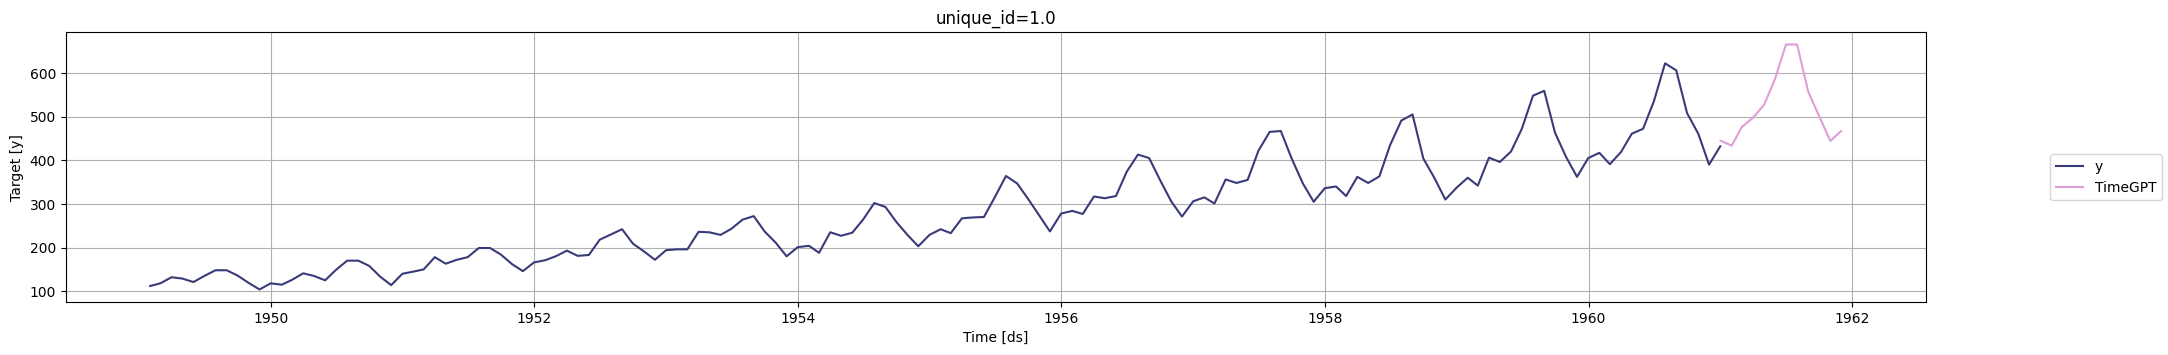

In [18]:
timegpt.plot(ap, fcst)

In [19]:
req = timegpt.request_df()

In [20]:
req

,created_at,endpoint,input_tokens,output_tokens,finetune_tokens
0,2024-03-29 00:46:26,forecast,144,12,3


In [21]:
# Anomaly detection 
pm_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/peyton_manning.csv')
pm_df.head()


,timestamp,value
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [22]:
timegpt_anomalies_df = timegpt.detect_anomalies(pm_df, time_col='timestamp', target_col='value', freq='D')

INFO:__main__:Validating inputs...
INFO:__main__:Preprocessing dataframes...
INFO:__main__:Calling Anomaly Detector Endpoint...


In [23]:
timegpt.request_df()

,created_at,endpoint,input_tokens,output_tokens,finetune_tokens
0,2024-03-29 00:46:39,detect_anomalies,2964,14665,0


In [15]:
# Cross-validation 
pm_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/peyton_manning.csv')
timegpt_cv_df, res = timegpt.cross_validation(
    pm_df, 
    h=7, 
    n_windows=5, 
    time_col='timestamp', 
    target_col='value', 
    freq='D',
)


INFO:__main__:Validating inputs...
INFO:__main__:Validating inputs...
INFO:__main__:Preprocessing dataframes...
INFO:__main__:Calling Forecast Endpoint...
INFO:__main__:Validating inputs...
INFO:__main__:Validating inputs...
INFO:__main__:Preprocessing dataframes...


{'forecast': {'columns': ['unique_id', 'ds', 'TimeGPT'], 'data': [['ts_0', '2015-12-17', 7.939553260803223], ['ts_0', '2015-12-18', 7.887511730194092], ['ts_0', '2015-12-19', 7.7666168212890625], ['ts_0', '2015-12-20', 7.931501865386963], ['ts_0', '2015-12-21', 8.312631607055664], ['ts_0', '2015-12-22', 8.201765060424805], ['ts_0', '2015-12-23', 8.029194831848145]]}, 'input_tokens': 2929, 'output_tokens': 7, 'finetune_tokens': 0}


INFO:__main__:Calling Forecast Endpoint...
INFO:__main__:Validating inputs...
INFO:__main__:Validating inputs...
INFO:__main__:Preprocessing dataframes...


{'forecast': {'columns': ['unique_id', 'ds', 'TimeGPT'], 'data': [['ts_0', '2015-12-24', 7.800054550170898], ['ts_0', '2015-12-25', 7.754588603973389], ['ts_0', '2015-12-26', 7.669259071350098], ['ts_0', '2015-12-27', 7.85870885848999], ['ts_0', '2015-12-28', 8.235979080200195], ['ts_0', '2015-12-29', 8.156147003173828], ['ts_0', '2015-12-30', 7.9251389503479]]}, 'input_tokens': 2936, 'output_tokens': 7, 'finetune_tokens': 0}


INFO:__main__:Calling Forecast Endpoint...
INFO:__main__:Validating inputs...
INFO:__main__:Validating inputs...
INFO:__main__:Preprocessing dataframes...


{'forecast': {'columns': ['unique_id', 'ds', 'TimeGPT'], 'data': [['ts_0', '2015-12-31', 8.254302024841309], ['ts_0', '2016-01-01', 7.991794586181641], ['ts_0', '2016-01-02', 7.776082515716553], ['ts_0', '2016-01-03', 8.207669258117676], ['ts_0', '2016-01-04', 8.617856979370117], ['ts_0', '2016-01-05', 8.439395904541016], ['ts_0', '2016-01-06', 8.242656707763672]]}, 'input_tokens': 2943, 'output_tokens': 7, 'finetune_tokens': 0}


INFO:__main__:Calling Forecast Endpoint...
INFO:__main__:Validating inputs...
INFO:__main__:Validating inputs...
INFO:__main__:Preprocessing dataframes...


{'forecast': {'columns': ['unique_id', 'ds', 'TimeGPT'], 'data': [['ts_0', '2016-01-07', 8.187920570373535], ['ts_0', '2016-01-08', 7.760076522827148], ['ts_0', '2016-01-09', 7.755465507507324], ['ts_0', '2016-01-10', 8.424907684326172], ['ts_0', '2016-01-11', 8.73046588897705], ['ts_0', '2016-01-12', 8.58137321472168], ['ts_0', '2016-01-13', 8.391382217407227]]}, 'input_tokens': 2950, 'output_tokens': 7, 'finetune_tokens': 0}


INFO:__main__:Calling Forecast Endpoint...
INFO:__main__:Validating inputs...


{'forecast': {'columns': ['unique_id', 'ds', 'TimeGPT'], 'data': [['ts_0', '2016-01-14', 7.960582256317139], ['ts_0', '2016-01-15', 7.7414960861206055], ['ts_0', '2016-01-16', 7.728490352630615], ['ts_0', '2016-01-17', 8.267574310302734], ['ts_0', '2016-01-18', 8.543140411376953], ['ts_0', '2016-01-19', 8.298713684082031], ['ts_0', '2016-01-20', 8.105557441711426]]}, 'input_tokens': 2957, 'output_tokens': 7, 'finetune_tokens': 0}


In [20]:
res

{'forecast': {'columns': ['unique_id', 'ds', 'TimeGPT'],
  'data': [['ts_0', '2016-01-14', 7.960582256317139],
   ['ts_0', '2016-01-15', 7.7414960861206055],
   ['ts_0', '2016-01-16', 7.728490352630615],
   ['ts_0', '2016-01-17', 8.267574310302734],
   ['ts_0', '2016-01-18', 8.543140411376953],
   ['ts_0', '2016-01-19', 8.298713684082031],
   ['ts_0', '2016-01-20', 8.105557441711426]]},
 'input_tokens': 2957,
 'output_tokens': 7,
 'finetune_tokens': 0}

In [ ]:
#----------------------------------------------------------------

In [ ]:
show_doc(TimeGPT.__init__, title_level=3, name='TimeGPT')

In [ ]:
#| hide
from contextlib import contextmanager

In [ ]:
#| hide
@contextmanager
def delete_env_var(key):
    original_value = os.environ.get(key)
    rm = False
    if key in os.environ:
        del os.environ[key]
        rm = True
    try:
        yield
    finally:
        if rm:
            os.environ[key] = original_value
# test token fail
with delete_env_var('TIMEGPT_TOKEN'):
    test_fail(
        lambda: TimeGPT(),
        contains='TIMEGPT_TOKEN',
    )

In [ ]:
#| hide
timegpt = TimeGPT()

In [ ]:
show_doc(TimeGPT.validate_token, title_level=2, name='TimeGPT.validate_token')

In [ ]:
#| hide
timegpt.validate_token()

In [ ]:
#| hide
_timegpt = TimeGPT(os.environ['TIMEGPT_CUSTOM_URL_TOKEN'], os.environ['TIMEGPT_CUSTOM_URL'])
_timegpt.validate_token()

In [ ]:
#| hide
test_fail(
    lambda: TimeGPT(token='transphobic').forecast(df=pd.DataFrame(), h=None, validate_token=True),
    contains='nixtla'
)

In [ ]:
#| hide
# test input_size
test_eq(
    timegpt.client.model_params(request=SingleSeriesForecast(freq='D'))['data']['detail'],
    {'input_size': 28, 'horizon': 7},
)

Now you can start to make forecasts! Let's import an example:

In [ ]:
#| hide
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

In [ ]:
#| hide
# test model change
df_test = df.copy()
df_test.columns = ["ds", "y"]
test_warns(
    lambda: timegpt.forecast(df_test, finetune_steps=2, h=12, model="timegpt-1"),
)
test_warns(
    lambda: timegpt.forecast(df_test, finetune_steps=2, h=12, model="timegpt-1-long-horizon"),
)
pd.testing.assert_frame_equal(
    timegpt.forecast(df_test, h=12, model="timegpt-1"),
    timegpt.forecast(df_test, h=12),
)
pd.testing.assert_frame_equal(
    timegpt.forecast(df_test, h=12, model="timegpt-1-long-horizon"),
    timegpt.forecast(df_test, h=12, model="long-horizon"),
)

In [ ]:
#| hide
# test finetune deprecation
test_warns(
    lambda: timegpt.forecast(df_test, finetune_steps=2, h=12),
)
test_warns(
    lambda: timegpt.forecast(df_test, finetune_steps=2, finetune_loss="mse", h=12),
)
pd.testing.assert_frame_equal(
    timegpt.forecast(df_test, finetune_steps=2, h=12),
    timegpt.forecast(df_test, fewshot_steps=2, h=12),
    atol=1,
    rtol=0,
)
pd.testing.assert_frame_equal(
    timegpt.forecast(df_test, finetune_steps=2, finetune_loss="mse", h=12),
    timegpt.forecast(df_test, fewshot_steps=2, fewshot_loss="mse", h=12),
    atol=1,
    rtol=0,
)


In [ ]:
#| hide
from typing import Callable
from utilsforecast.data import generate_series

In [ ]:
#| hide
# test date_features with multiple series
# and different ends
test_series = generate_series(n_series=2, min_length=5, max_length=20)
h = 12
fcst_test_series = timegpt.forecast(test_series, h=12, date_features=['dayofweek'])
uids = test_series['unique_id']
for uid in uids:
    test_eq(
        fcst_test_series.query('unique_id == @uid')['ds'].values,
        pd.date_range(periods=h + 1, start=test_series.query('unique_id == @uid')['ds'].max())[1:].astype(str),
    )

In [ ]:
#| hide
# test quantiles
test_fail(
    lambda: timegpt.forecast(
        df=df, 
        h=12, 
        time_col='timestamp', 
        target_col='value', 
        level=[80], 
        quantiles=[0.2, 0.3]
    ),
    contains='not both'
)
test_qls = list(np.arange(0.1, 1, 0.1))
exp_q_cols = [f"TimeGPT-q-{int(100 * q)}" for q in test_qls]
def test_method_qls(method, **kwargs):
    df_qls = method(
        df=df, 
        h=12, 
        time_col='timestamp', 
        target_col='value', 
        quantiles=test_qls,
        **kwargs
    )
    assert all(col in df_qls.columns for col in exp_q_cols)
    # test monotonicity of quantiles
    df_qls.apply(lambda x: x.is_monotonic_increasing, axis=1).sum() == len(exp_q_cols)
test_method_qls(timegpt.forecast)
test_method_qls(timegpt.forecast, add_history=True)
test_method_qls(timegpt.cross_validation)

In [ ]:
#| hide
# test num partitions
# we need to be sure that we can recover the same results
# using a for loop
# A: be aware that num partitons can produce different results
# when used fewshot_steps
def test_num_partitions_same_results(method: Callable, num_partitions: int, **kwargs):
    res_partitioned = method(**kwargs, num_partitions=num_partitions)
    res_no_partitioned = method(**kwargs, num_partitions=1)
    sort_by = ['unique_id', 'ds']
    if 'cutoff' in res_partitioned:
        sort_by.extend(['cutoff'])
    pd.testing.assert_frame_equal(
        res_partitioned.sort_values(sort_by).reset_index(drop=True), 
        res_no_partitioned.sort_values(sort_by).reset_index(drop=True),
        rtol=1e-2,
        atol=1e-2,
    )
    
freqs = {'D': 7, 'W-THU': 52, 'Q-DEC': 8, '15T': 4 * 24 * 7}
for freq, h in freqs.items():
    df_freq = generate_series(
        10, 
        min_length=500 if freq != '15T' else 1_200, 
        max_length=550 if freq != '15T' else 2_000,
    )
    #df_freq['y'] = df_freq['y'].astype(np.float32)
    df_freq['ds'] = df_freq.groupby('unique_id')['ds'].transform(
        lambda x: pd.date_range(periods=len(x), freq=freq, end='2023-01-01')
    )
    min_size = df_freq.groupby('unique_id').size().min()
    test_num_partitions_same_results(
        timegpt.detect_anomalies,
        level=98,
        df=df_freq,
        num_partitions=2,
    )
    test_num_partitions_same_results(
        timegpt.cross_validation,
        h=7,
        n_windows=2,
        df=df_freq,
        num_partitions=2,
    )
    test_num_partitions_same_results(
        timegpt.forecast,
        df=df_freq,
        h=7,
        add_history=True,
        num_partitions=2,
    )

In [ ]:
#| hide
from itertools import product
from time import time, sleep
from unittest.mock import patch

from requests.exceptions import HTTPError

In [ ]:
#| hide
from httpx import ReadTimeout

In [ ]:
#| hide
def test_retry_behavior(side_effect, max_retries=5, retry_interval=5, max_wait_time=40, should_retry=True, sleep_seconds=5):
    mock_timegpt = TimeGPT(
        max_retries=max_retries, 
        retry_interval=retry_interval, 
        max_wait_time=max_wait_time,
    )
    init_time = time()
    with patch('nixtlats.client.Nixtla.forecast_multi_series', side_effect=side_effect):
        test_fail(
            lambda: mock_timegpt.forecast(df=df, h=12, time_col='timestamp', target_col='value'),
        )
    total_mock_time = time() - init_time
    if should_retry:
        approx_expected_time = min((max_retries - 1) * retry_interval, max_wait_time)
        upper_expected_time = min(max_retries * retry_interval, max_wait_time)
        assert total_mock_time >= approx_expected_time, "It is not retrying as expected"
        # preprocessing time before the first api call should be less than 60 seconds
        assert total_mock_time - upper_expected_time - (max_retries - 1) * sleep_seconds <= sleep_seconds
    else:
        assert total_mock_time <= max_wait_time 

In [ ]:
#| hide
# we want the api to retry in these cases
def raise_api_error_with_text(*args, **kwargs):
    raise ApiError(
        status_code=503, 
        body="""
        <html><head>
        <meta http-equiv="content-type" content="text/html;charset=utf-8">
        <title>503 Server Error</title>
        </head>
        <body text=#000000 bgcolor=#ffffff>
        <h1>Error: Server Error</h1>
        <h2>The service you requested is not available at this time.<p>Service error -27.</h2>
        <h2></h2>
        </body></html>
        """)
test_retry_behavior(raise_api_error_with_text, retry_interval=1)

In [ ]:
#| hide
# we want the api to not retry in these cases
# here A is assuming that the endpoint responds always
# with a json
def raise_api_error_with_json(*args, **kwargs):
    raise ApiError(
        status_code=503, 
        body=dict(detail='Please use numbers'),
    )
test_retry_behavior(raise_api_error_with_json, should_retry=False)

In [ ]:
#| hide
# test resilience of api calls

def raise_read_timeout_error(*args, **kwargs):
    print(f'raising ReadTimeout error after {sleep_seconds} seconds')
    sleep(sleep_seconds)
    raise ReadTimeout
    
def raise_http_error(*args, **kwargs):
    print('raising HTTP error')
    raise HTTPError(response=dict(status_code=503))
    
combs = [
    (2, 5, 30),
    (10, 1, 5),
]
side_effects = [raise_read_timeout_error, raise_http_error]

for (max_retries, retry_interval, max_wait_time), side_effect in product(combs, side_effects):
    test_retry_behavior(
        max_retries=max_retries, 
        retry_interval=retry_interval, 
        max_wait_time=max_wait_time, 
        side_effect=side_effect,
    )
    

In [ ]:
#| hide
# test pass dataframe with index
df_ds_index = df.set_index('timestamp')
df_ds_index.index = pd.DatetimeIndex(df_ds_index.index, freq='MS')
fcst_inferred_df_index = timegpt.forecast(df_ds_index, h=10, time_col='timestamp', target_col='value')
anom_inferred_df_index = timegpt.detect_anomalies(df_ds_index, time_col='timestamp', target_col='value')
fcst_inferred_df = timegpt.forecast(df, h=10, time_col='timestamp', target_col='value')
anom_inferred_df = timegpt.detect_anomalies(df, time_col='timestamp', target_col='value')
pd.testing.assert_frame_equal(fcst_inferred_df_index, fcst_inferred_df)
pd.testing.assert_frame_equal(anom_inferred_df_index, anom_inferred_df)
for freq in ['Y', 'W-MON', 'Q-DEC', 'H']:
    df_ds_index.index = pd.date_range(end='2023-01-01', periods=len(df), freq=freq)
    df_ds_index.index.name = 'timestamp'
    df_test = df_ds_index.reset_index()
    fcst_inferred_df_index = timegpt.forecast(df_ds_index, h=10, time_col='timestamp', target_col='value')
    fcst_inferred_df = timegpt.forecast(df_test, h=10, time_col='timestamp', target_col='value')
    pd.testing.assert_frame_equal(fcst_inferred_df_index, fcst_inferred_df)

In [ ]:
show_doc(TimeGPT.plot, name='TimeGPT.plot', title_level=2)

In [ ]:
#| hide
timegpt.plot(df, time_col='timestamp', target_col='value', engine='plotly')

In [ ]:
show_doc(TimeGPT.forecast, title_level=2)

In [ ]:
#| hide
# test we recover the same <mean> forecasts
# with and without restricting input
# (add_history)

def test_equal_fcsts_add_history(**kwargs):
    fcst_no_rest_df = timegpt.forecast(**kwargs, add_history=True)
    fcst_no_rest_df = fcst_no_rest_df.groupby('unique_id').tail(kwargs['h']).reset_index(drop=True)
    fcst_rest_df = timegpt.forecast(**kwargs)
    pd.testing.assert_frame_equal(
        fcst_no_rest_df,
        fcst_rest_df,
    )
    return fcst_rest_df

freqs = {'D': 7, 'W-THU': 52, 'Q-DEC': 8, '15T': 4 * 24 * 7}
for freq, h in freqs.items():
    df_freq = generate_series(
        10, 
        min_length=500 if freq != '15T' else 1_200, 
        max_length=550 if freq != '15T' else 2_000,
    )
    df_freq['ds'] = df_freq.groupby('unique_id')['ds'].transform(
        lambda x: pd.date_range(periods=len(x), freq=freq, end='2023-01-01')
    )
    kwargs = dict(
        df=df_freq,
        h=h,
    )
    fcst_1_df = test_equal_fcsts_add_history(**{**kwargs, 'model': 'short-horizon'})
    fcst_2_df = test_equal_fcsts_add_history(**{**kwargs, 'model': 'long-horizon'})
    test_fail(
        lambda: pd.testing.assert_frame_equal(fcst_1_df, fcst_2_df),
        contains='(column name="TimeGPT") are different',
    )
    # add test num_partitions
    

In [ ]:
#| hide
#test same results custom url
timegpt_custom = TimeGPT(
    token=os.environ['TIMEGPT_CUSTOM_URL_TOKEN'], 
    environment=os.environ['TIMEGPT_CUSTOM_URL'],
)
# forecast method
fcst_kwargs = dict(
    df=df, 
    h=12, 
    level=[90, 95], 
    add_history=True, 
    time_col='timestamp', 
    target_col='value',
)
fcst_df = timegpt.forecast(**fcst_kwargs)
fcst_df_custom = timegpt_custom.forecast(**fcst_kwargs)
pd.testing.assert_frame_equal(
    fcst_df,
    fcst_df_custom,
)
# anomalies method
anomalies_kwargs = dict(
    df=df, 
    level=99,
    time_col='timestamp', 
    target_col='value',
)
anomalies_df = timegpt.detect_anomalies(**anomalies_kwargs)
anomalies_df_custom = timegpt.detect_anomalies(**anomalies_kwargs)
pd.testing.assert_frame_equal(
    anomalies_df,
    anomalies_df_custom,
)

In [ ]:
#| hide
# test different results for different models
fcst_kwargs['model'] = 'short-horizon'
fcst_timegpt_1 = timegpt.forecast(**fcst_kwargs)
fcst_kwargs['model'] = 'long-horizon'
fcst_timegpt_long = timegpt.forecast(**fcst_kwargs)
test_fail(
    lambda: pd.testing.assert_frame_equal(fcst_timegpt_1[['TimeGPT']], fcst_timegpt_long[['TimeGPT']]),
    contains='(column name="TimeGPT") are different'
)

In [ ]:
#| hide
# test different results for different models
# anomalies
anomalies_kwargs['model'] = 'short-horizon'
anomalies_timegpt_1 = timegpt.detect_anomalies(**anomalies_kwargs)
anomalies_kwargs['model'] = 'long-horizon'
anomalies_timegpt_long = timegpt.detect_anomalies(**anomalies_kwargs)
test_fail(
    lambda: pd.testing.assert_frame_equal(anomalies_timegpt_1[['TimeGPT']], anomalies_timegpt_long[['TimeGPT']]),
    contains='(column name="TimeGPT") are different'
)

In [ ]:
#| hide
# test unsupported model
fcst_kwargs['model'] = 'a-model'
test_fail(
    lambda: timegpt.forecast(**fcst_kwargs),
    contains='unsupported model',
)

In [ ]:
#| hide
# test unsupported model
anomalies_kwargs['model'] = 'my-awesome-model'
test_fail(
    lambda: timegpt.detect_anomalies(**anomalies_kwargs),
    contains='unsupported model',
)

In [ ]:
#| hide
# test make future dataframe for one series
df_ = df.rename(columns={'timestamp': 'ds', 'value': 'y'})
df_.insert(0, 'unique_id', 'AirPassengers')
df_actual_future = df_.tail(12)[['unique_id', 'ds']]
df_history = df_.drop(df_actual_future.index)
df_future = _TimeGPTModel(client=timegpt.client, h=12, freq='MS').make_future_dataframe(df_history)
pd.testing.assert_frame_equal(
    df_actual_future.reset_index(drop=True),
    df_future,
)

In [ ]:
#| hide
# test add date features
date_features = ['year', 'month']
df_date_features, future_df = _TimeGPTModel(
    client=timegpt.client,
    h=12, 
    freq='MS', 
    date_features=date_features,
    date_features_to_one_hot=None,
).add_date_features(df_,  X_df=None)
assert all(col in df_date_features for col in date_features)
assert all(col in future_df for col in date_features)

In [ ]:
show_doc(TimeGPT.cross_validation, title_level=2)

In [ ]:
#| hide
# cross validation tests
df_copy = df_.copy()
pd.testing.assert_frame_equal(
    df_copy,
    df_,
)
df_test = df_.groupby('unique_id').tail(12)
df_train = df_.drop(df_test.index)
hyps = [
    # fewshot steps is unstable due
    # to numerical reasons
    # dict(fewshot_steps=2),
    dict(),
    dict(clean_ex_first=False),
    dict(date_features=['month']),
    dict(level=[80, 90]),
    #dict(level=[80, 90], fewshot_steps=2),
]

In [ ]:
#| hide
# test exogenous variables cv
df_ex_ = df_.copy()
df_ex_['exogenous_var'] = df_ex_['y'] + np.random.normal(size=len(df_ex_))
x_df_test = df_test.drop(columns='y').merge(df_ex_.drop(columns='y'))
for hyp in hyps:
    main_logger.info(f'Hyperparameters: {hyp}')
    main_logger.info('\n\nPerforming forecast\n')
    fcst_test = timegpt.forecast(df_train.merge(df_ex_.drop(columns='y')), h=12, X_df=x_df_test, **hyp)
    fcst_test = df_test[['unique_id', 'ds', 'y']].merge(fcst_test)
    fcst_test = fcst_test.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    main_logger.info('\n\nPerforming Cross validation\n')
    fcst_cv = timegpt.cross_validation(df_ex_, h=12, **hyp)
    fcst_cv = fcst_cv.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    main_logger.info('\n\nVerify difference\n')
    pd.testing.assert_frame_equal(
        fcst_test,
        fcst_cv.drop(columns='cutoff'),
        #rtol=1e-2,
    )


In [ ]:
#| hide
for hyp in hyps:
    fcst_test = timegpt.forecast(df_train, h=12, **hyp)
    fcst_test = df_test[['unique_id', 'ds', 'y']].merge(fcst_test)
    fcst_test = fcst_test.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    fcst_cv = timegpt.cross_validation(df_, h=12, **hyp)
    fcst_cv = fcst_cv.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    pd.testing.assert_frame_equal(
        fcst_test,
        fcst_cv.drop(columns='cutoff'),
        rtol=1e-2,
    )

In [ ]:
#| hide
for hyp in hyps:
    fcst_test = timegpt.forecast(df_train, h=12, **hyp)
    fcst_test.insert(2, 'y', df_test['y'].values)
    fcst_test = fcst_test.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    fcst_cv = timegpt.cross_validation(df_, h=12, **hyp)
    fcst_cv = fcst_cv.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    pd.testing.assert_frame_equal(
        fcst_test,
        fcst_cv.drop(columns='cutoff'),
        rtol=1e-2,
    )

In [ ]:
#| hide
from nixtlats.date_features import SpecialDates

In [ ]:
#| hide
# test add callables
date_features = [SpecialDates({'first_dates': ['2021-01-1'], 'second_dates': ['2021-01-01']})]
df_daily = df_.copy()
df_daily['ds'] = pd.date_range(end='2021-01-01', periods=len(df_daily))
df_date_features, future_df = _TimeGPTModel(
    client=timegpt.client,
    h=12, 
    freq='D', 
    date_features=date_features,
    date_features_to_one_hot=None,
).add_date_features(df_,  X_df=None)
assert all(col in df_date_features for col in ['first_dates', 'second_dates'])
assert all(col in future_df for col in ['first_dates', 'second_dates'])

In [ ]:
#| hide
# test add date features one hot encoded
date_features = ['year', 'month']
date_features_to_one_hot = ['month']
df_date_features, future_df = _TimeGPTModel(
    client=timegpt.client,
    h=12, 
    freq='D', 
    date_features=date_features,
    date_features_to_one_hot=date_features_to_one_hot,
).add_date_features(df_,  X_df=None)

In [ ]:
#| hide
# test future dataframe for multiple series
df_ = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df_actual_future = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-future-ex-vars.csv')
df_future = _TimeGPTModel(
        client=timegpt.client, 
        h=24, 
        freq='H',
    ).make_future_dataframe(df_[['unique_id', 'ds', 'y']])
pd.testing.assert_frame_equal(
    df_actual_future[['unique_id', 'ds']],
    df_future,
)

In [ ]:
# test pass dataframe with index
df_ds_index = df_.set_index('ds')[['unique_id', 'y']]
df_ds_index.index = pd.DatetimeIndex(df_ds_index.index)
fcst_inferred_df_index = timegpt.forecast(df_ds_index, h=10)
anom_inferred_df_index = timegpt.detect_anomalies(df_ds_index)
fcst_inferred_df = timegpt.forecast(df_[['ds', 'unique_id', 'y']], h=10)
anom_inferred_df = timegpt.detect_anomalies(df_[['ds', 'unique_id', 'y']])
pd.testing.assert_frame_equal(fcst_inferred_df_index, fcst_inferred_df, atol=1e-3)
pd.testing.assert_frame_equal(anom_inferred_df_index, anom_inferred_df, atol=1e-3)
df_ds_index = df_ds_index.groupby('unique_id').tail(80)
for freq in ['Y', 'W-MON', 'Q-DEC', 'H']:
    df_ds_index.index = np.concatenate(
        df_ds_index['unique_id'].nunique() * [pd.date_range(end='2023-01-01', periods=80, freq=freq)]
    )
    df_ds_index.index.name = 'ds'
    fcst_inferred_df_index = timegpt.forecast(df_ds_index, h=10)
    df_test = df_ds_index.reset_index()
    fcst_inferred_df = timegpt.forecast(df_test, h=10)
    pd.testing.assert_frame_equal(fcst_inferred_df_index, fcst_inferred_df, atol=1e-3)

In [ ]:
#| hide
# test add date features with exogenous variables 
# and multiple series
date_features = ['year', 'month']
df_date_features, future_df = _TimeGPTModel(
    client=timegpt.client,
    h=24, 
    freq='H', 
    date_features=date_features,
    date_features_to_one_hot=None,
).add_date_features(df_,  X_df=df_actual_future)
assert all(col in df_date_features for col in date_features)
assert all(col in future_df for col in date_features)
pd.testing.assert_frame_equal(
    df_date_features[df_.columns],
    df_,
)
pd.testing.assert_frame_equal(
    future_df[df_actual_future.columns],
    df_actual_future,
)

In [ ]:
#| hide
# test add date features one hot with exogenous variables 
# and multiple series
date_features = ['month', 'day']
df_date_features, future_df = _TimeGPTModel(
    client=timegpt.client,
    h=24, 
    freq='H', 
    date_features=date_features,
    date_features_to_one_hot=date_features,
).add_date_features(df_,  X_df=df_actual_future)
pd.testing.assert_frame_equal(
    df_date_features[df_.columns],
    df_,
)
pd.testing.assert_frame_equal(
    future_df[df_actual_future.columns],
    df_actual_future,
)

In [ ]:
#| hide
# test warning horizon too long
timegpt.forecast(df=df.tail(3), h=100, time_col='timestamp', target_col='value')

In [ ]:
#| hide 
# test short horizon with add_history
test_fail(
    lambda: timegpt.forecast(df=df.tail(3), h=12, time_col='timestamp', target_col='value', add_history=True),
    contains='be sure'
)

In [ ]:
#| hide 
# test short horizon with finetunning
test_fail(
    lambda: timegpt.forecast(df=df.tail(3), h=12, time_col='timestamp', target_col='value', fewshot_steps=10, fewshot_loss='mae'),
    contains='be sure'
)

In [ ]:
#| hide 
# test short horizon with level
test_fail(
    lambda: timegpt.forecast(df=df.tail(3), h=12, time_col='timestamp', target_col='value', level=[80, 90]),
    contains='be sure'
)

In [ ]:
#| hide
# test custom url
# same results
_timegpt_fcst_df = _timegpt.forecast(df=df, h=12, time_col='timestamp', target_col='value')
timegpt_fcst_df = timegpt.forecast(df=df, h=12, time_col='timestamp', target_col='value')
pd.testing.assert_frame_equal(
    _timegpt_fcst_df,
    timegpt_fcst_df,
)

In [ ]:
#| hide
# test using index as time_col
# same results
df_test = df.copy()
df_test["timestamp"] = pd.to_datetime(df_test["timestamp"])
df_test.set_index(df_test["timestamp"], inplace=True)
df_test.drop(columns="timestamp", inplace=True)

# Using user_provided time_col and freq
timegpt_anomalies_df_1 = timegpt.detect_anomalies(df, time_col='timestamp', target_col='value', freq= 'M')
# Infer time_col and freq from index
timegpt_anomalies_df_2 = timegpt.detect_anomalies(df_test, time_col='timestamp', target_col='value')

pd.testing.assert_frame_equal(
    timegpt_anomalies_df_1,
    timegpt_anomalies_df_2 
)

In [ ]:
show_doc(TimeGPT.detect_anomalies, title_level=2)